In [18]:
import torch
import torch.nn as nn
from datasets import load_dataset, load_from_disk
from src.models.blm.finetune.chat_format import convert_stories_to_chat_format

In [19]:
ds = load_dataset(
    "skeskinen/TinyStories-Instruct-hf",
    cache_dir="/home/pranav-pc/projects/OpenTransformer/multiformer/data/downloads",
)
ds

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 2476533
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 25028
    })
})

In [20]:
ds = ds.map(lambda example: {"is_present": "Story:" in example["text"]}, num_proc=28)

In [21]:
assert sum(ds["train"]["is_present"]) == len(ds["train"])

In [22]:
ds = ds.filter(lambda example: example["is_present"], num_proc=30)
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'is_present'],
        num_rows: 2476533
    })
    validation: Dataset({
        features: ['text', 'is_present'],
        num_rows: 25026
    })
})

In [31]:
example = ds["train"][0]["text"]

In [35]:
example.split("Story:")

['Features: Dialogue\nWords: quit, oak, gloomy\nSummary: Sara and Ben were playing in the park, but Sara wanted to go home because it was cold and dark. Ben convinced her to stay and play, but eventually agreed to go home and have hot cocoa.\n',
 ' \n\n\n\nSara and Ben were playing in the park. They liked to climb the big oak tree and pretend they were birds. They made nests with leaves and twigs and sang songs.\n\nBut today, the sky was gloomy and the wind was cold. Sara felt sad and cold. She wanted to go home and have some hot cocoa.\n\n"Ben, I want to quit," she said. "It\'s too cold and dark. Let\'s go home."\n\nBen looked at Sara and frowned. He liked the oak tree and the park. He wanted to stay and play.\n\n"No, Sara, don\'t quit," he said. "It\'s fun here. Look, there\'s a squirrel. Let\'s chase it."\n\nSara shook her head. She didn\'t want to chase the squirrel. She wanted to go home and have some hot cocoa.\n\n"Please, Ben, let\'s go home," she said. "We can play here another

In [38]:
def text_to_dict(text):
    example_dict = {}

    sections = text.split("Story:")

    for section in sections[:-1]:
        lines = section.split("\n")
        for line in lines:
            if line.startswith("Features:"):
                example_dict["Features"] = line.replace("Features: ", "")
            elif line.startswith("Words:"):
                example_dict["Words"] = line.replace("Words: ", "")
            elif line.startswith("Summary:"):
                example_dict["Summary"] = line.replace("Summary: ", "")

    example_dict["Story"] = sections[-1].strip()
    return example_dict


# Example text
example_text = ds["train"][0]["text"]

# Convert text to dictionary
example_dict = text_to_dict(example_text)
print(example_dict)

{'Features': 'Dialogue', 'Words': 'quit, oak, gloomy', 'Summary': 'Sara and Ben were playing in the park, but Sara wanted to go home because it was cold and dark. Ben convinced her to stay and play, but eventually agreed to go home and have hot cocoa.', 'Story': 'Sara and Ben were playing in the park. They liked to climb the big oak tree and pretend they were birds. They made nests with leaves and twigs and sang songs.\n\nBut today, the sky was gloomy and the wind was cold. Sara felt sad and cold. She wanted to go home and have some hot cocoa.\n\n"Ben, I want to quit," she said. "It\'s too cold and dark. Let\'s go home."\n\nBen looked at Sara and frowned. He liked the oak tree and the park. He wanted to stay and play.\n\n"No, Sara, don\'t quit," he said. "It\'s fun here. Look, there\'s a squirrel. Let\'s chase it."\n\nSara shook her head. She didn\'t want to chase the squirrel. She wanted to go home and have some hot cocoa.\n\n"Please, Ben, let\'s go home," she said. "We can play here 

In [39]:
from pprint import pprint

pprint(example_dict)

{'Features': 'Dialogue',
 'Story': 'Sara and Ben were playing in the park. They liked to climb the big '
          'oak tree and pretend they were birds. They made nests with leaves '
          'and twigs and sang songs.\n'
          '\n'
          'But today, the sky was gloomy and the wind was cold. Sara felt sad '
          'and cold. She wanted to go home and have some hot cocoa.\n'
          '\n'
          '"Ben, I want to quit," she said. "It\'s too cold and dark. Let\'s '
          'go home."\n'
          '\n'
          'Ben looked at Sara and frowned. He liked the oak tree and the park. '
          'He wanted to stay and play.\n'
          '\n'
          '"No, Sara, don\'t quit," he said. "It\'s fun here. Look, there\'s a '
          'squirrel. Let\'s chase it."\n'
          '\n'
          "Sara shook her head. She didn't want to chase the squirrel. She "
          'wanted to go home and have some hot cocoa.\n'
          '\n'
          '"Please, Ben, let\'s go home," she said. 

In [7]:
ds = ds.map(
    lambda example: {
        "text": convert_stories_to_chat_format(example["text"]).replace("\n\n\n", "")
    },
    batched=False,
    num_proc=30,
    remove_columns=ds.column_names["train"],
)

In [8]:
train, validation = ds["train"], ds["validation"]

In [9]:
ds = ds.map(lambda example: {"len": len(example["text"])})

<Axes: ylabel='Count'>

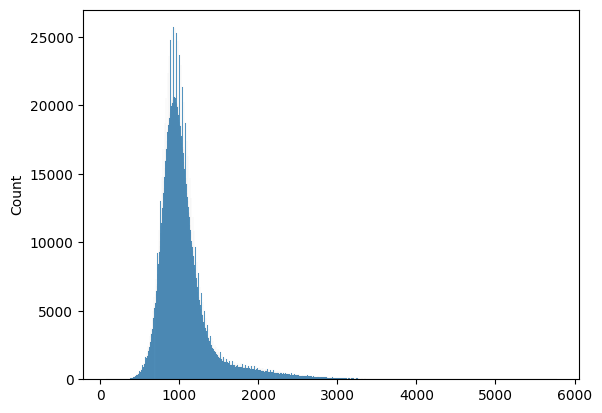

In [10]:
import seaborn as sns

sns.histplot(ds["train"]["len"])

In [11]:
sum([i < 65 for i in ds["train"]["len"]])

0

In [17]:
print(ds["train"][91]["text"])

User:
Summary: Lily and Tom help their mom make a cake by stirring the ingredients, getting milk, and finding a clean pan. They enjoy licking the spoon and can't wait to eat the cake.
Features: Dialogue
Words: stir, jug, clean
Assistant: 

Lily and Tom were helping Mom make a cake. Mom gave them a big bowl with flour, sugar, eggs and butter. She said, "You can stir this with a spoon. Be careful not to spill it."

Lily and Tom took turns to stir the bowl. They liked to see how the ingredients mixed together. They made funny noises as they stirred. "Swish, swish, swish," said Lily. "Squish, squish, squish," said Tom.

Mom smiled and said, "You are doing a great job. Now we need some milk. Can you get the jug from the fridge?" Lily and Tom ran to the fridge and opened the door. They saw a big jug with a picture of a cow on it. They grabbed the jug and brought it to Mom.

Mom poured some milk into the bowl and said, "Now we need to stir it some more. Can you help me?" Lily and Tom nodded a

In [43]:
import json


# Function to process a single example and generate prompts
def process_example(example):
    prompts = []

    # Summary prompt
    summary = example.get("Summary", "")
    if summary:
        prompts.append({"prompt": "Summary Prompt", "text": f"Summary: {summary}"})

    # Features prompt
    features = example.get("Features", "")
    if features:
        prompts.append({"prompt": "Features Prompt", "text": f"Features: {features}"})

    # Words prompt
    words = example.get("Words", "")
    if words:
        words_list = words.split(", ")
        words_text = ", ".join([f'"{word}"' for word in words_list])
        prompts.append({"prompt": "Words Prompt", "text": f"Words: {words_text}"})

    # Combined prompts
    combined_text = f"Summary: {summary}\nFeatures: {features}\nWords: {words}"
    if combined_text:
        prompts.append({"prompt": "Combined Prompts", "text": combined_text})

    return prompts


# Function to process the entire dataset
def process_dataset(dataset):
    processed_data = []
    for example in dataset:
        prompts = process_example(example)
        processed_data.extend(prompts)
    return processed_data


# # Sample dataset (replace this with your actual dataset loading code)
# with open("your_dataset.json", "r") as file:
#     dataset = json.load(file)

# Process the dataset
# processed_data = process_dataset(dataset)

# Write the prompts to a file
# with open("prompts.txt", "w") as file:
#     for item in processed_data:
#         file.write(f"{item['prompt']}:\n{item['text']}\n\n")

In [44]:
process_example(example_dict)

[{'prompt': 'Summary Prompt',
  'text': 'Summary: Sara and Ben were playing in the park, but Sara wanted to go home because it was cold and dark. Ben convinced her to stay and play, but eventually agreed to go home and have hot cocoa.'},
 {'prompt': 'Features Prompt', 'text': 'Features: Dialogue'},
 {'prompt': 'Words Prompt', 'text': 'Words: "quit", "oak", "gloomy"'},
 {'prompt': 'Combined Prompts',
  'text': 'Summary: Sara and Ben were playing in the park, but Sara wanted to go home because it was cold and dark. Ben convinced her to stay and play, but eventually agreed to go home and have hot cocoa.\nFeatures: Dialogue\nWords: quit, oak, gloomy'}]

In [13]:
ds = load_from_disk(
    "/home/pranav-pc/projects/OpenTransformer/multiformer/data/processed/TinyStories-Instruct-hf"
)

In [14]:
ds["train"][0]

{'text': 'User:\nFeatures: Dialogue\nWords: quit, oak, gloomy\nSummary: Sara and Ben were playing in the park, but Sara wanted to go home because it was cold and dark. Ben convinced her to stay and play, but eventually agreed to go home and have hot cocoa.\nAssistant: \nSara and Ben were playing in the park. They liked to climb the big oak tree and pretend they were birds. They made nests with leaves and twigs and sang songs.\n\nBut today, the sky was gloomy and the wind was cold. Sara felt sad and cold. She wanted to go home and have some hot cocoa.\n\n"Ben, I want to quit," she said. "It\'s too cold and dark. Let\'s go home."\n\nBen looked at Sara and frowned. He liked the oak tree and the park. He wanted to stay and play.\n\n"No, Sara, don\'t quit," he said. "It\'s fun here. Look, there\'s a squirrel. Let\'s chase it."\n\nSara shook her head. She didn\'t want to chase the squirrel. She wanted to go home and have some hot cocoa.\n\n"Please, Ben, let\'s go home," she said. "We can pla

In [3]:
from datasets import load_from_disk

ds = load_from_disk(
    "/home/pranav-pc/projects/OpenTransformer/multiformer/data/interim/TinyStories-Instruct-hf_train_65>tk>1024.hf"
)

In [6]:
ds = ds.map(lambda example: {"len": len(example["idx"])})

Map:   0%|          | 0/2473061 [00:00<?, ? examples/s]

<Axes: ylabel='Count'>

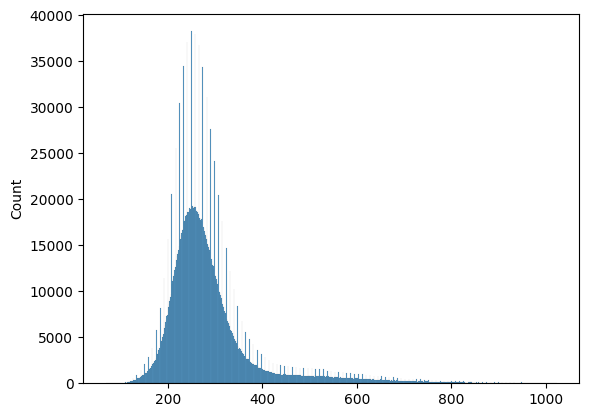

In [8]:
import seaborn as sns

sns.histplot(ds["len"])